# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В моем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Мне нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.

Загрузите и подготовьте данные.

Обучите разные модели. Для каждой попробуйте различные гиперпараметры.

Проанализируйте скорость работы и качество моделей.

Примечания:

Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:

del features_train 

# Описание данных

Данные находятся в файле /datasets/autos.csv

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)

## Подготовка данных

Инсталирую catboost.

In [ ]:
#!pip install catboost

Инсталирую lightgbm.

In [ ]:
#! pip install lightgbm

Загружу все необходимые библиотеки.

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

import math
import matplotlib.pyplot as plt

from catboost import Pool, CatBoostRegressor, cv

from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

Загружу исходные данные в переменную df, посмотрю на первые 5 значений и общую информацию по данным.

In [2]:
try:  
    df = pd.read_csv('C:/project/autos.csv')
except OSError as e:
    df = pd.read_csv('/datasets/autos.csv')
display(df.head())
display(df.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

Таблица представляет собой данные по каждому объявлению о продаже автомобиля. В данных имеются пропуски.

Для начала удалю стобцы, не влияющие на предсказание модели. Столбец 'DateCrawled' удалю после удаления дубликатов.

In [3]:
df = df.drop(columns=['DateCreated', 'LastSeen', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode'])
display(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Напишу функцию, которая позволит выделить уникальные значения столбца, а также количество NaN.

In [4]:
def data_values(data):
    for column in data.columns:
        print('Значения столбца', column)
        print(data[column].sort_values().unique())
        print('Количество NaN:', data[column].isna().sum())

Применю функцию.

In [5]:
data_values(df)

Значения столбца DateCrawled
['2016-03-05 14:06:22' '2016-03-05 14:06:23' '2016-03-05 14:06:24' ...
 '2016-04-07 14:36:55' '2016-04-07 14:36:56' '2016-04-07 14:36:58']
Количество NaN: 0
Значения столбца Price
[    0     1     2 ... 19998 19999 20000]
Количество NaN: 0
Значения столбца VehicleType
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
Количество NaN: 37490
Значения столбца RegistrationYear
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 

В данных имеются следующие артефакты:

- В столбце Price присутствуют нули, а также очень маленькие значения;
- В столбце VehicleType присутствуют NaN;
- В столбце RegistrationYear присутствуют слишком маленькие и слишком большие значения;
- В столбце Gearbox присутствуют NaN;
- В столбце Power присутствуют слишком маленькие и слишком большие значения;
- В столбце Model присутствуют NaN;
- В столбце Kilometer нет артефактов;
- В столбце FuelType присутствуют NaN;
- В столбце Brand нет артефактов;
- В столбце NotRepaired присутствуют NaN.

Построю диаграмму корреляции.

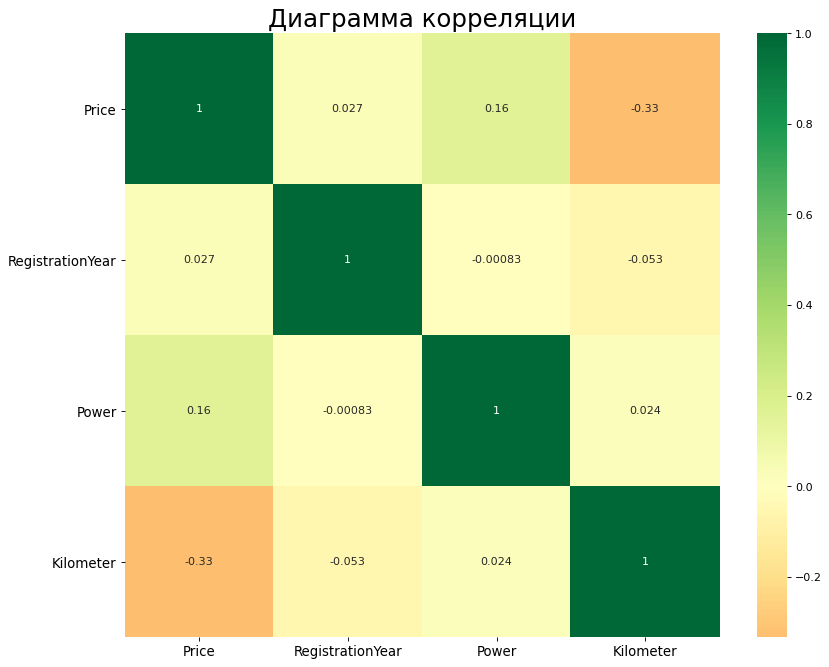

In [6]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.title('Диаграмма корреляции', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.show()

Сильно отрицательное влияние пробега на цену. Но не настолько, чтобы исключить один из столбцов.

### Столбец 'RegistrationYear'

Построю графики по годам регистрации автомобиля.

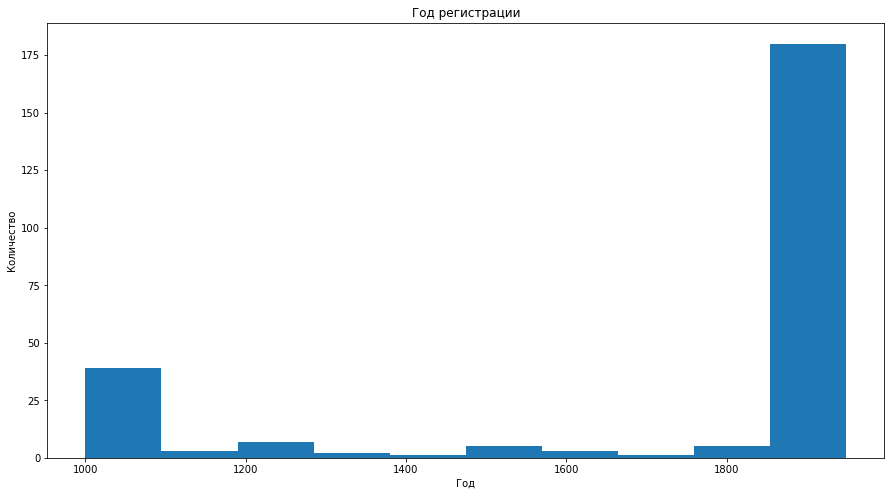

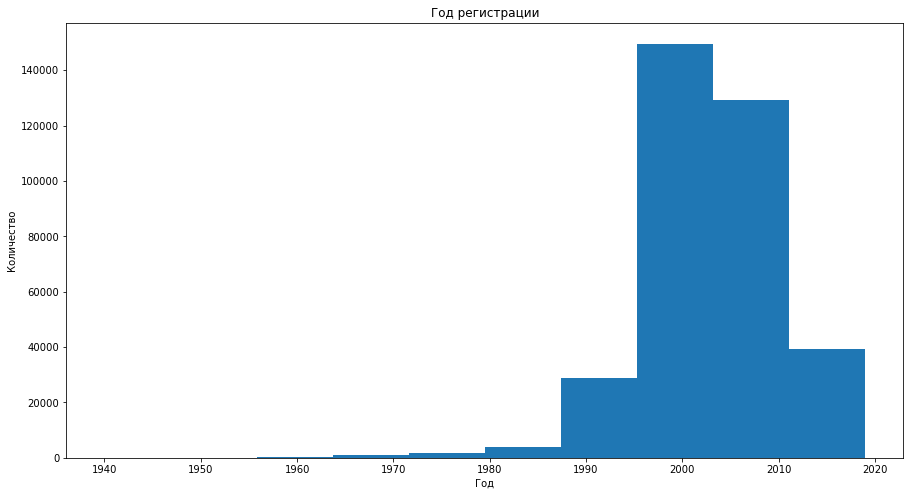

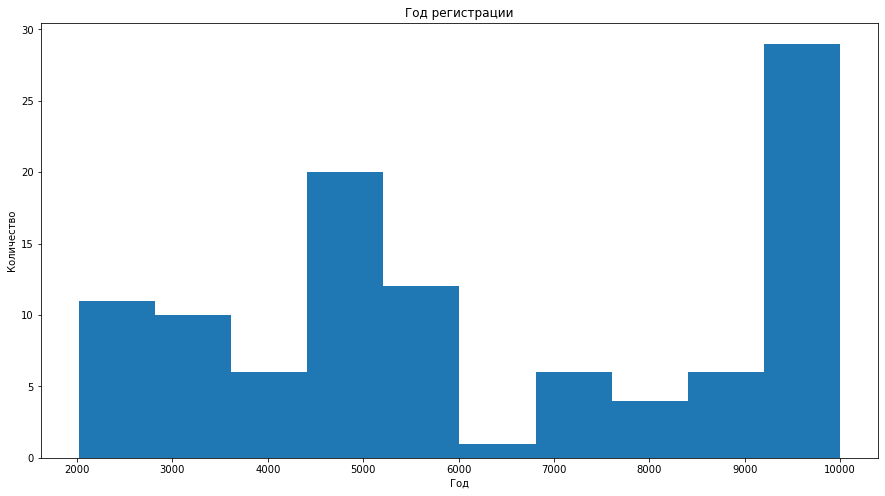

In [7]:
def reg_graph(min, max):
    plt.figure(figsize=(15,8))
    df['RegistrationYear'].plot(kind="hist", range=(min, max));
    plt.title("Год регистрации");
    plt.xlabel("Год");
    plt.ylabel("Количество");

reg_graph(1000, 1949)
reg_graph(1940, 2019)
reg_graph(2020, 9999)

Считаю, что значения ранее 1960 года и позже 2016 года можно заменить на эти крайние значения. Так как по условию мне даны данные за 2019 год, следовательно автомобилей позже 2019 в данных быть не может. Нижняя граница определена по графику - ниже 1960 года мало значений и маловероятно, что автомобили тех годов имеются в продаже в таком количестве. 

In [8]:
def year(row):
    if row[3] < 1960:
        row[3] = 1960
    elif row[3] > 2019:
        row[3] = 2019
    return row

In [9]:
df = df.apply(year, axis=1)

### Столбец 'Model'

Заполню часть пропусков по названию бренда и года регистрации автомобиля, так как в опеределенный год обычно выходит одна марка автомобиля-три марки у одного бренда.

In [10]:
df["Model"] = df["Model"].fillna(df.groupby(['Brand', 'RegistrationYear'])["Model"].transform('first'))
df["Model"].isna().sum()

3395

### Столбец 'VehicleType'

Заполню часть пропусков по названию бренда и модели автомобиля, так как у определенный модели чаще всего один тип кузова.

In [11]:
df["VehicleType"] = df["VehicleType"].fillna(df.groupby(['Brand', 'Model'])["VehicleType"].transform('first'))
df["VehicleType"].isna().sum()

1046

### Столбец 'Price'

Сделаю срез данных по стоимости, отсею всё, что ниже 600 евро. В итоге потеряно 13% данных.

In [12]:
df = df.query('600 <= Price')
df.shape[0]

308043

In [13]:
print((354369-308043)/354369)

0.13072813931241165


### Столбец 'Gearbox'

Заполню часть пропусков по бренду и модели автомобиля. Также присвою значению 'auto' - 1, а значению 'manual' - 0.

In [14]:
df["Gearbox"] = df["Gearbox"].fillna(df.groupby(['Brand', 'Model'])["Gearbox"].transform('first'))
df['Gearbox'].replace('auto', 1, inplace=True)
df['Gearbox'].replace('manual', 0, inplace=True)
df["Gearbox"].isna().sum()

436

### Столбец 'Power'

Построю графики значений мощности автомобилей.

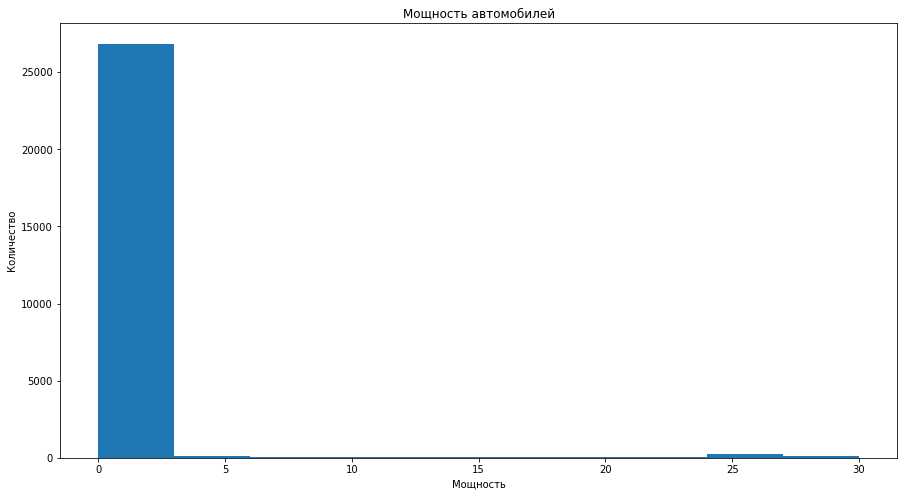

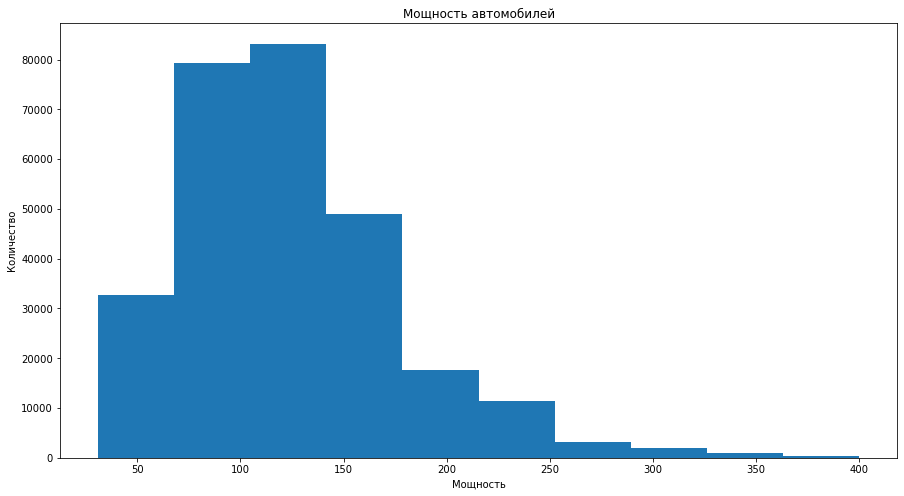

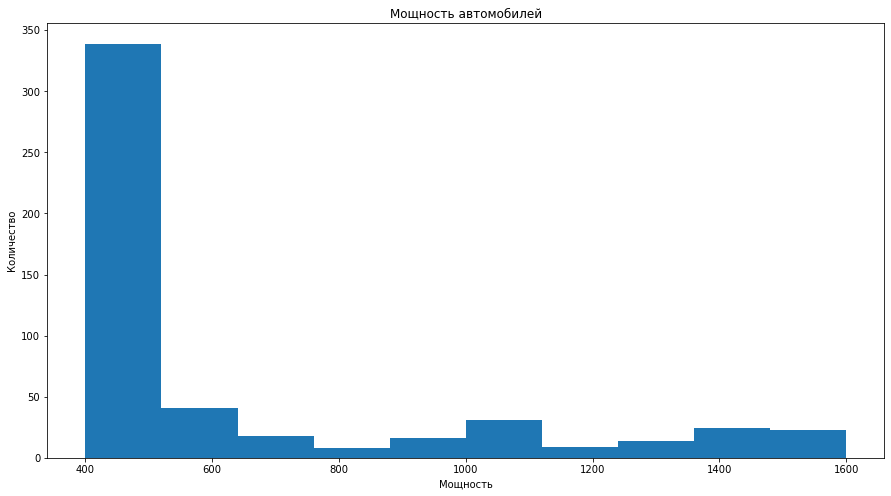

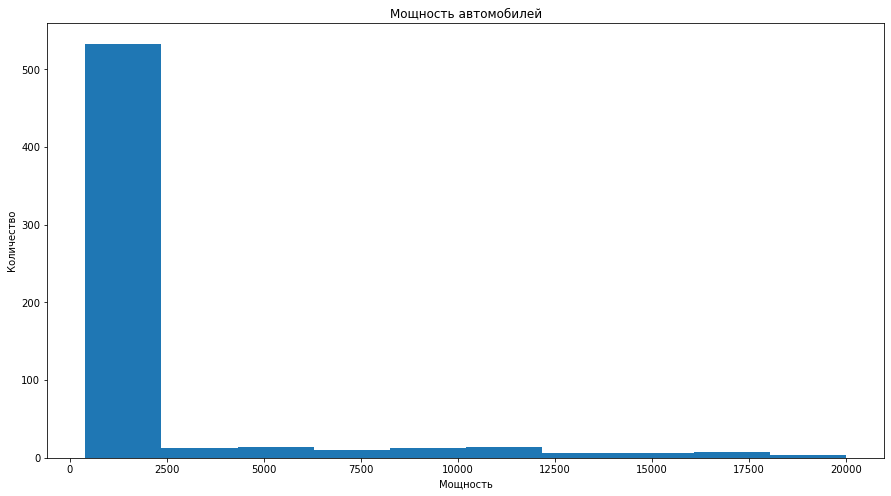

In [15]:
def power_graph(min, max):
    plt.figure(figsize=(15,8))
    df['Power'].plot(kind="hist", range=(min, max));
    plt.title("Мощность автомобилей");
    plt.xlabel("Мощность");
    plt.ylabel("Количество");

power_graph(0, 30)
power_graph(31, 400)
power_graph(400, 1600)
power_graph(401, 20000)

Имеется большое количество нулей, очень большие и маленькие значения. Проверю какие автомобили указаны с очень большим количеством лошадиных сил.

In [16]:
pow = df.query('1600 <= Power <= 30000')
pow.head(15)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
7661,2016-04-02 19:25:25,1499,small,1999,0.0,7515,lupo,150000,petrol,volkswagen,NaN
9664,2016-03-14 20:06:19,2599,bus,2016,0.0,1779,zafira,150000,petrol,opel,no
19092,2016-03-20 17:54:04,9750,wagon,2005,1.0,2729,5er,150000,gasoline,bmw,no
20050,2016-03-26 19:46:06,2200,sedan,2002,1.0,1704,e_klasse,150000,NaN,mercedes_benz,yes
20283,2016-03-25 18:48:26,2000,wagon,2003,0.0,1900,c5,150000,gasoline,citroen,yes
22281,2016-03-17 05:03:48,3999,sedan,1998,0.0,1993,3er,150000,cng,bmw,NaN
25232,2016-03-28 19:57:39,10900,bus,2009,0.0,10520,caddy,150000,gasoline,volkswagen,no
32784,2016-03-22 14:58:27,9500,bus,1986,1.0,1659,other,40000,petrol,chevrolet,no
33952,2016-03-09 11:37:03,3740,small,2006,0.0,6920,aygo,90000,NaN,toyota,no
35168,2016-03-16 00:18:43,2599,bus,2016,0.0,1779,zafira,150000,petrol,opel,no


Кораблей не оказалось, поэтому ставлю заглушку на очень маленькие и очень большие значения.

In [17]:
def power(row):
    if row[5] < 25:
        row[5] = np.nan
    elif row[5] > 1000:
        row[5] = np.nan
    return row

In [18]:
df = df.apply(power, axis=1)

Заполню часть пропусков по бренду и модели автомобиля.

In [19]:
df["Power"] = df["Power"].fillna(df.groupby(['Brand', 'Model'])["Power"].transform('mean'))
df["Power"].isna().sum()

851

### Столбец 'FuelType'

Заполню часть пропусков по бренду и модели автомобиля.

In [20]:
df["FuelType"] = df["FuelType"].fillna(df.groupby(['Brand', 'Model'])["FuelType"].transform('first'))
df["FuelType"].isna().sum()

465

### Столбец 'NotRepaired'

Считаю, что пропуски в данном столбце говорят о том, что автомобиль не ремонтировался и поэтому нет такого указания. Заменю пропуски на нули.

In [21]:
df["NotRepaired"] = df["NotRepaired"].fillna(0)
df["NotRepaired"].isna().sum()

0

Установлю значение 1 для ремонтированных автомобилей и 0 для автомобилей без ремонта.

In [22]:
df['NotRepaired'].replace('no', 0, inplace=True)
df['NotRepaired'].replace('yes', 1, inplace=True)

Удалю дубликаты и оставшиеся пропуски.

In [23]:
df = df.dropna()
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305541 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DateCrawled       305541 non-null  object 
 1   Price             305541 non-null  int64  
 2   VehicleType       305541 non-null  object 
 3   RegistrationYear  305541 non-null  int64  
 4   Gearbox           305541 non-null  float64
 5   Power             305541 non-null  float64
 6   Model             305541 non-null  object 
 7   Kilometer         305541 non-null  int64  
 8   FuelType          305541 non-null  object 
 9   Brand             305541 non-null  object 
 10  NotRepaired       305541 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 28.0+ MB


Удалю столбец 'DateCrawled'.

In [24]:
df = df.drop(columns=['DateCrawled'])
display(df)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,0.0,190.000000,a4,125000,gasoline,audi,1
2,9800,suv,2004,1.0,163.000000,grand,125000,gasoline,jeep,0
3,1500,small,2001,0.0,75.000000,golf,150000,petrol,volkswagen,0
4,3600,small,2008,0.0,69.000000,fabia,90000,gasoline,skoda,0
5,650,sedan,1995,0.0,102.000000,3er,150000,petrol,bmw,1
...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,0.0,225.000000,leon,150000,petrol,seat,1
354363,1150,bus,2000,0.0,125.012209,zafira,150000,petrol,opel,0
354366,1199,convertible,2000,1.0,101.000000,fortwo,125000,petrol,smart,0
354367,9200,bus,1996,0.0,102.000000,transporter,150000,gasoline,volkswagen,0


Приведу числовые данные к типу int64.

In [25]:
df = df.astype({"Price": "int64"})
df = df.astype({"Gearbox": "int64"})
df = df.astype({"Power": "int64"})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305541 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             305541 non-null  int64 
 1   VehicleType       305541 non-null  object
 2   RegistrationYear  305541 non-null  int64 
 3   Gearbox           305541 non-null  int64 
 4   Power             305541 non-null  int64 
 5   Model             305541 non-null  object
 6   Kilometer         305541 non-null  int64 
 7   FuelType          305541 non-null  object
 8   Brand             305541 non-null  object
 9   NotRepaired       305541 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 25.6+ MB


In [26]:
df.describe(include='all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
count,305541.000000,305541,305541.000000,305541.000000,305541.000000,305541,305541.000000,305541,305541,305541.000000
unique,NaN,8,NaN,NaN,NaN,249,NaN,7,39,NaN
top,NaN,sedan,NaN,NaN,NaN,golf,NaN,petrol,volkswagen,NaN
freq,NaN,87221,NaN,NaN,NaN,26475,NaN,198278,66784,NaN
mean,5026.101832,NaN,2003.717151,0.209396,123.134931,NaN,127908.873114,NaN,NaN,0.076468
std,4512.447955,NaN,6.930766,0.406878,53.190625,NaN,37094.838453,NaN,NaN,0.265745
min,600.000000,NaN,1960.000000,0.000000,25.000000,NaN,5000.000000,NaN,NaN,0.000000
25%,1590.000000,NaN,2000.000000,0.000000,84.000000,NaN,125000.000000,NaN,NaN,0.000000
50%,3399.000000,NaN,2004.000000,0.000000,116.000000,NaN,150000.000000,NaN,NaN,0.000000
75%,7000.000000,NaN,2008.000000,0.000000,150.000000,NaN,150000.000000,NaN,NaN,0.000000


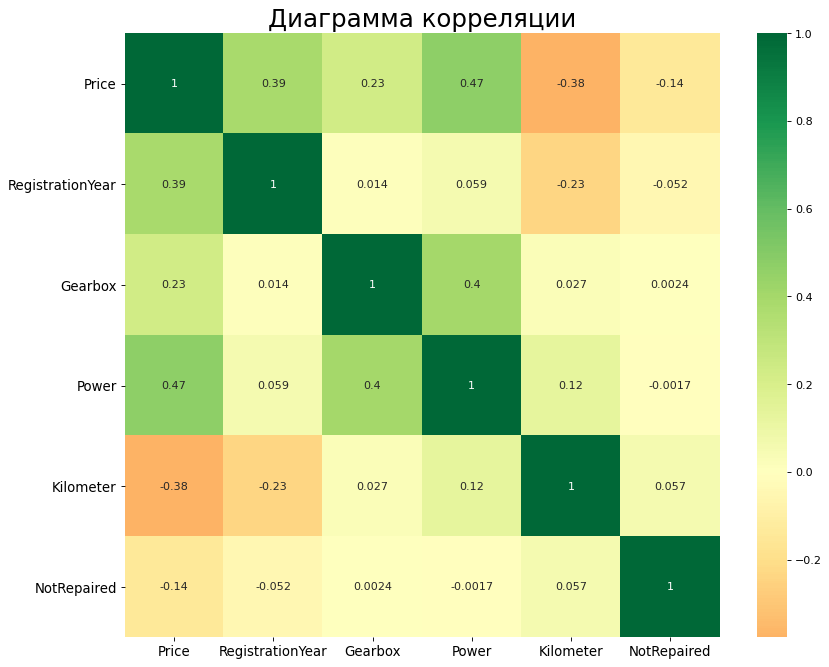

In [27]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.title('Диаграмма корреляции', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.show()

Добавились новые признаки, но в целом картина не изменилась.

In [ ]:
#! pip install phik

In [28]:
import phik
from phik import resources, report

In [29]:
df.phik_matrix()

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Gearbox', 'Power', 'Kilometer', 'NotRepaired']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
Price,1.000000,0.244134,0.629814,0.300498,0.436318,0.552286,0.310469,0.220070,0.310483,0.200307
VehicleType,0.244134,1.000000,0.190984,0.267277,0.365270,0.914260,0.181969,0.321902,0.612454,0.050504
RegistrationYear,0.629814,0.190984,1.000000,0.097969,0.169898,0.626504,0.378279,0.239859,0.316718,0.089354
Gearbox,0.300498,0.267277,0.097969,1.000000,0.516220,0.644974,0.029294,0.134498,0.502977,0.002467
Power,0.436318,0.365270,0.169898,0.516220,1.000000,0.693467,0.110165,0.207101,0.475319,0.018601
Model,0.552286,0.914260,0.626504,0.644974,0.693467,1.000000,0.450301,0.547342,0.998348,0.092258
Kilometer,0.310469,0.181969,0.378279,0.029294,0.110165,0.450301,1.000000,0.163586,0.278382,0.066853
FuelType,0.220070,0.321902,0.239859,0.134498,0.207101,0.547342,0.163586,1.000000,0.315201,0.016764
Brand,0.310483,0.612454,0.316718,0.502977,0.475319,0.998348,0.278382,0.315201,1.000000,0.041348
NotRepaired,0.200307,0.050504,0.089354,0.002467,0.018601,0.092258,0.066853,0.016764,0.041348,1.000000


### Вывод

Предобработка данных завершена. Пропуски отсутствуют. Данные готовы к построению моделей предсказания.

## Обучение моделей

В ходе данного проекта я обучу следующие модели:
- LinearRegression;
- Ridge;
- DecisionTreeRegressor;
- CatBoostRegressor;
- LGBMRegressor.

### Создание выборок

Создам два различных типа выборок - для моделей, принимающих категориальные данные и для тех кто их не принимает.

Изменю тип данных на "category".

In [30]:
df_cat = df.astype({"VehicleType": "category"})
df_cat = df_cat.astype({"Model": "category"})
df_cat = df_cat.astype({"FuelType": "category"})
df_cat = df_cat.astype({"Brand": "category"})
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305541 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             305541 non-null  int64   
 1   VehicleType       305541 non-null  category
 2   RegistrationYear  305541 non-null  int64   
 3   Gearbox           305541 non-null  int64   
 4   Power             305541 non-null  int64   
 5   Model             305541 non-null  category
 6   Kilometer         305541 non-null  int64   
 7   FuelType          305541 non-null  category
 8   Brand             305541 non-null  category
 9   NotRepaired       305541 non-null  int64   
dtypes: category(4), int64(6)
memory usage: 17.8 MB


Создам обучающую и валидационную выборки.

In [32]:
features_cat = df_cat.drop(['Price'],axis=1)
target_cat = df_cat['Price']

train_features, valid_features, train_target, valid_target = train_test_split(features_cat, target_cat, test_size=0.7, random_state=12345)

print('Размер обучающей выборки', train_features.shape[0])
print('Размер валидационной выборки', valid_features.shape[0])

Размер обучающей выборки 91662
Размер валидационной выборки 213879


Для некотегориальных моделей применю метод pd.get_dummies.

In [33]:
df_lin = pd.get_dummies(df, drop_first=True)
display(df_lin.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305541 entries, 1 to 354368
Columns: 305 entries, Price to Brand_volvo
dtypes: int64(6), uint8(299)
memory usage: 103.4 MB


None

Создам обучающую, валидационную и тестовую выборки.

In [34]:
features_lin = df_lin.drop(['Price'],axis=1)
target_lin = df_lin['Price']

train_features_lin, valid_features_lin, train_target_lin, valid_target_lin = train_test_split(features_lin, target_lin, test_size=0.7, random_state=12345)

print('Размер обучающей выборки', train_features_lin.shape[0])
print('Размер валидационной выборки', valid_features_lin.shape[0])

Размер обучающей выборки 91662
Размер валидационной выборки 213879


### Линейная регрессия

Подберу наилучшие гиперпараметры для линейной регрессии.

In [35]:
%%time

model_lin = LinearRegression()
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=12345)
param = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
search = GridSearchCV(model_lin, param, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
result = search.fit(train_features_lin, train_target_lin)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -1958.3829772751426
Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Wall time: 2min 48s


### Ridge

Подберу наилучшие гиперпараметры для регрессии Ridge.

In [36]:
%%time

model = Ridge()
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=12345)
param = {
    'solver':['svd', 'cholesky', 'lsqr'],
    'alpha': [1e-3, 1e-1, 1],
    'fit_intercept':[True, False],
    'normalize':[True, False]
}
search = GridSearchCV(model, param, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
result = search.fit(train_features_lin, train_target_lin)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -1958.2330897026154
Best Hyperparameters: {'alpha': 0.001, 'fit_intercept': True, 'normalize': True, 'solver': 'lsqr'}
Wall time: 10min 28s


### DecisionTreeClassifier

Подберу наилучшие гиперпараметры для модели DecisionTreeClassifier.

In [37]:
%%time

parametrs = {'max_leaf_nodes': list(range(10, 20)),          
             'ccp_alpha': [0.1, 0.001],            
             'max_depth': list(range(2, 6)),             
             'criterion': ['gini', 'entropy']             
            }

clf = DecisionTreeClassifier(random_state=12345)

grid = GridSearchCV(clf, parametrs, cv=3)

grid.fit(train_features_lin, train_target_lin)

display(grid.best_params_)

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 19}

Wall time: 14min 7s


### CatBoostRegressor

Подберу наилучшие гиперпараметры для модели CatBoostRegressor.

In [39]:
%%time

regressor = CatBoostRegressor(cat_features=['VehicleType','FuelType','Brand','Model']) 

hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'depth': [2, 4],
                'random_state':[12345],
                'l2_leaf_reg': [1, 3],
                'verbose':[False]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)

print(clf.best_params_)

{'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
Wall time: 41min 25s


### LGBMRegressor

Подберу наилучшие гиперпараметры для модели LGBMRegressor.

In [40]:
%%time

regressor = LGBMRegressor(categorical_feature=['VehicleType','FuelType','Brand','Model']) 
hyperparams = [{'num_leaves':[20, 200], 
                'learning_rate':[0.01, 0.1, 0.3],
                'min_data_in_leaf':[20, 100],
                'max_depth': [3, 12],
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)

print(clf.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

### Вывод

Для всех моделей получил наилучшие показатели гиперпараметров.

## Анализ моделей

### Линейная регрессия

Вычислю RMSE на валидационной выборке.

In [44]:
%%time

model_lin = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
model_lin.fit(train_features_lin, train_target_lin)
predictions_lin = model_lin.predict(valid_features_lin)
RMSE_lin = mean_squared_error(valid_target_lin, predictions_lin) **0.5  
print(RMSE_lin)

2778.5462339199407
Wall time: 3.94 s


### Ridge

Вычислю RMSE на валидационной выборке.

In [42]:
%%time

model_rid = Ridge(alpha=0.001, fit_intercept=True, normalize=True, solver='lsqr')
model_rid.fit(train_features_lin, train_target_lin)
predictions_rid = model_rid.predict(valid_features_lin)
RMSE_rid = mean_squared_error(valid_target_lin, predictions_rid) **0.5  
print(RMSE_rid)

2778.969324707698
Wall time: 2.66 s


### DecisionTreeClassifier

Вычислю RMSE на валидационной выборке.

In [45]:
%%time

model_dec = DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=5, max_leaf_nodes=19, random_state=12345)
model_dec.fit(train_features_lin, train_target_lin)
predictions_dec = model_dec.predict(valid_features_lin)
RMSE_dec = mean_squared_error(valid_target_lin, predictions_dec) **0.5  
print(RMSE_dec)

2969.490197198164
Wall time: 7.19 s


### CatBoostRegressor

Вычислю RMSE на валидационной выборке.

In [46]:
%%time

model_cat = CatBoostRegressor(cat_features=['VehicleType','FuelType','Brand','Model'],
                                   depth=4,
                                   l2_leaf_reg=3,
                                   learning_rate=0.5,
                                   verbose=False,
                                   random_state=12345)
model_cat.fit(train_features, train_target)
predictions_cat = model_cat.predict(valid_features)
RMSE_cat = mean_squared_error(valid_target, predictions_cat) **0.5  
print(RMSE_cat)

1711.6540021468334
Wall time: 56.7 s


### LGBMRegressor

Вычислю RMSE на валидационной выборке.

In [47]:
%%time

model_light = LGBMRegressor(categorical_feature=['VehicleType','FuelType','Brand','Model'],
                                   max_depth=12,
                                   min_data_in_leaf=20,
                                   learning_rate=0.1,
                                   num_leaves=200,
                                   random_state=12345)
model_light.fit(train_features, train_target)
predictions_light = model_light.predict(valid_features)
RMSE_light = mean_squared_error(valid_target, predictions_light) **0.5  
print(RMSE_light)

1649.9820905144854
Wall time: 2.58 s


Сведу полученные значения метрики RMSE в табллицу.

In [48]:
final_RMSE = {'Model': ['LinearRegression', 'Ridge', 'DecisionTreeClassifier', 'CatBoostRegressor', 'LGBMRegressor'],
              'RMSE': [2778.55, 2778.97, 2969.49, 1711.65, 1649.98]} 
 
final_RMSE_df = pd.DataFrame(final_RMSE) 
  
print(final_RMSE_df.sort_values(by='RMSE', ascending=True)) 

                    Model     RMSE
4           LGBMRegressor  1649.98
3       CatBoostRegressor  1711.65
0        LinearRegression  2778.55
1                   Ridge  2778.97
2  DecisionTreeClassifier  2969.49


### Вывод

После анализа модели на тестовой выборке наилучшей признана модель LGBMRegressor (RMSE=1649.98), немного хуже модель CatBoostRegressor (RMSE=1711.65), наихудшие модели - DecisionTreeClassifier (RMSE=2969.49), LinearRegression (RMSE=2778.55), Ridge (RMSE=2778.97).

## Общий вывод

В ходе проекта я провел подготовку данных по объявлениям поддержаных автомобилей.

Обучил несколько моделей, среди которых наилучший результат показала модель LGBMRegressor. CatBoostRegressor показал результат чуть хуже но модель при этом обучалась на 40 минут дольше.

Считаю, что заказчику необходимо рекомендовать модель LGBMRegressor со следующими гиперпараметрами:
- max_depth=12,
- min_data_in_leaf=20,
- learning_rate=0.1,
- num_leaves=200,
- random_state=12345